<a href="https://colab.research.google.com/github/LoopMint/angelatancapstone-app/blob/main/CP_Read_CSV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Use Gradio to create web apps that displays csv data onto an interactive user interface**

In [9]:
#use the latest version
!pip install --upgrade gradio

# **Use ReportLab library to download into PDF**

In [10]:
!pip install reportlab

#**Use TensorFlow to build neural networks and train models to make predictions on university rankings**

In [11]:
!pip install tensorflow

# **Prompt user to upload the QS Ranking CSV File**

In [12]:
from google.colab import files

#triggers a file picker dialog in browser
uploaded = files.upload()

# Get the uploaded file name dynamically
for fn in uploaded.keys():
    file_path = fn
    print(f"File uploaded: {file_path}")


Saving QSRanking.csv to QSRanking (1).csv
File uploaded: QSRanking (1).csv


# **Import libraries**

*   pandas as pd â†’ for loading CSV
*   gradio as gr â†’ for building the interactive web app & dashboard.
*   tensorflow / keras â†’ for building and training deep learning models (classification, regression, Siamese).
*   numpy as np â†’ for numerical operations.
*   sklearn.preprocessing.StandardScaler â†’ scales your features so they have mean =  0 and standard deviation = 1  #this is a data preprocessing tool for dataset to make DLM accurate and stable, otherwise bias towards large numeric values.
*   sklearn.model_selection.train_test_split â†’ splits data into training + testing validation sets.
*   matplotlib.pyplot as plt â†’ creates charts and plots.
*   io.BytesIO + base64 â†’ converts plots/images so they can be displayed in Gradio.
*   reportlab â†’ generates PDF reports (eg. for pairwise ranking analysis).
*   tempfile â†’ creates temporary files for storing charts and PDFs before download.
*   os â†’ interact with operating system

ðŸ“Š Total records: 1403 universities


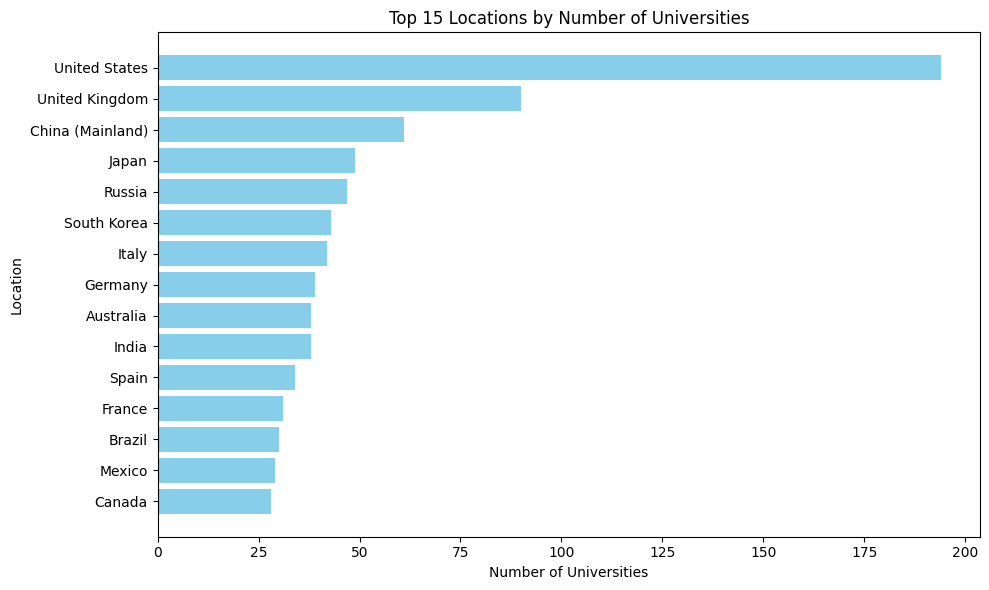

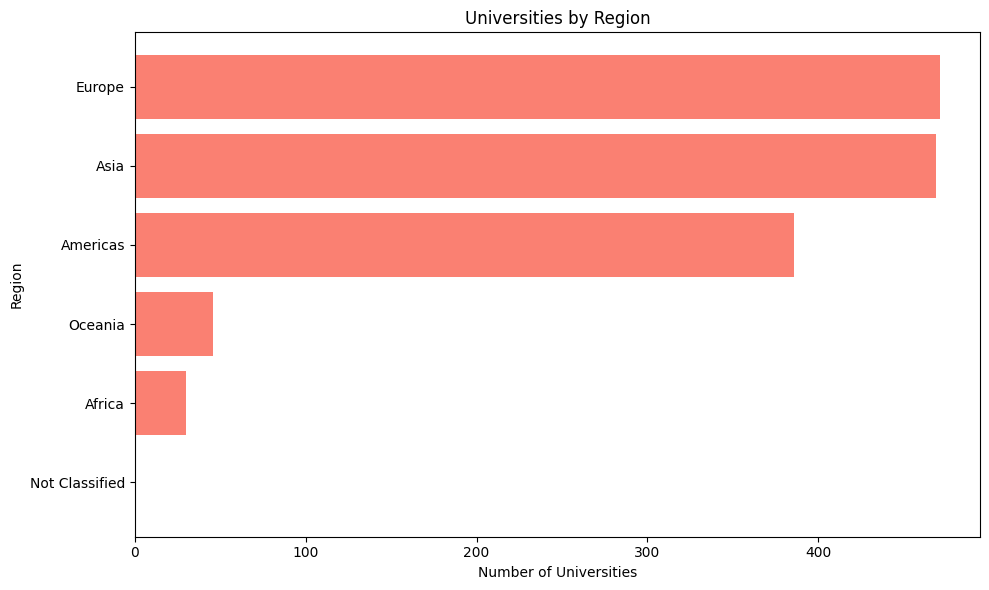

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://1c56976441637b39f4.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, Model, Input
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score # Import metrics
import matplotlib.pyplot as plt
from io import BytesIO
import base64
from reportlab.lib.pagesizes import letter
from reportlab.pdfgen import canvas
import os
import gradio as gr

# Load and clean data
file_path = 'QSRanking.csv'  # replace with your actual path
df = pd.read_csv(file_path, encoding='latin1')
if 'RANK_2024' in df.columns:
    df = df.drop(columns=['RANK_2024'])
df['RANK_2025'] = pd.to_numeric(df['RANK_2025'], errors='coerce').fillna(1402)
df['Top100'] = np.where(df['RANK_2025'] <= 100, 1, 0)
feature_cols = ['Academic_Reputation_Score', 'Employer_Reputation_Score',
                'Citations_per_Faculty_Score', 'Faculty_Student_Score',
                'International_Faculty_Score']
df = df.dropna(subset=feature_cols + ['Institution_Name', 'Top100'])


X = df[feature_cols].values
y_class = df['Top100'].values
y_reg = df['RANK_2025'].values

# Summary statistics
print(f"ðŸ“Š Total records: {df.shape[0]} universities")

# Show Chart - Top 15 Locations
if 'Location' in df.columns:
    loc_counts = df['Location'].value_counts().nlargest(15)
    plt.figure(figsize=(10, 6))
    plt.barh(loc_counts.index[::-1], loc_counts.values[::-1], color='skyblue')
    plt.title("Top 15 Locations by Number of Universities")
    plt.xlabel("Number of Universities")
    plt.ylabel("Location")
    plt.tight_layout()
    plt.show()  #display chart

# Show Chart - Universities by Region
if 'Region' in df.columns:
    reg_counts = df['Region'].value_counts()
    plt.figure(figsize=(10, 6))
    plt.barh(reg_counts.index[::-1], reg_counts.values[::-1], color='salmon')
    plt.title("Universities by Region")
    plt.xlabel("Number of Universities")
    plt.ylabel("Region")
    plt.tight_layout()
    plt.show() #display chart

# Preprocess
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Classification Model
X_train, X_val, y_train_c, y_val_c = train_test_split(X_scaled, y_class, test_size=0.2, random_state=42)
model_class = tf.keras.Sequential([
    Input(shape=(X.shape[1],)),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])
model_class.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_class.fit(X_train, y_train_c, epochs=20, validation_data=(X_val, y_val_c), verbose=0)

# Regression Model
X_train_r, X_val_r, y_train_r, y_val_r = train_test_split(X_scaled, y_reg, test_size=0.2, random_state=42)
model_reg = tf.keras.Sequential([
    Input(shape=(X.shape[1],)),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
])
model_reg.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
model_reg.fit(X_train_r, y_train_r, epochs=20, validation_data=(X_val_r, y_val_r), verbose=0)

# Siamese Model
def build_siamese_model(input_dim):
    base = tf.keras.Sequential([
        Input(shape=(input_dim,)),
        layers.Dense(64, activation='relu'),
        layers.Dense(32, activation='relu')
    ])
    input_a = Input(shape=(input_dim,))
    input_b = Input(shape=(input_dim,))
    encoded_a = base(input_a)
    encoded_b = base(input_b)
    diff = layers.Subtract()([encoded_a, encoded_b])
    out = layers.Dense(1, activation='sigmoid')(diff)
    return Model([input_a, input_b], out)

model_rank = build_siamese_model(X.shape[1])
model_rank.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

def create_pairs(X, y_rank):
    pairs_a, pairs_b, labels = [], [], []
    for i in range(len(X)):
        for j in range(i + 1, len(X)):
            pairs_a.append(X[i])
            pairs_b.append(X[j])
            labels.append(1 if y_rank[i] < y_rank[j] else 0)
    return np.array(pairs_a), np.array(pairs_b), np.array(labels)

X_a, X_b, y_rank_pair = create_pairs(X_scaled, y_reg)
model_rank.fit([X_a, X_b], y_rank_pair, epochs=5, batch_size=256, verbose=0)

# Gradio Interface
with gr.Blocks() as demo:
    gr.Markdown("## ðŸŒŸ 2025 QS University Ranking AI Dashboard")
    gr.Markdown("Data source: QS World University Rankings 2025")

    # New Tab - Dataset Overview
    with gr.Tab("ðŸ“„ Raw Dataset"):
        gr.Dataframe(value=df, label="University Dataset", interactive=False, wrap=True)
        dataframe_output = gr.Dataframe(value=df, label="QS Ranking Data")
        total_records = df.shape[0]
        total_regions = df['Region'].nunique() if 'Region' in df.columns else "N/A"
        total_locations = df['Location'].nunique() if 'Location' in df.columns else "N/A"
        summary = (
            f"**Total Records:** {total_records} &nbsp;&nbsp;&nbsp;&nbsp;"
            f"**Total Regions:** {total_regions} &nbsp;&nbsp;&nbsp;&nbsp;"
            f"**Total Locations:** {total_locations}"
        )
        gr.Markdown(summary)

    # Existing Tabs
    with gr.Tab("University Ranking Prediction"):
        univ_input = gr.Textbox(label="Enter university name:")
        model_type = gr.Radio(["Classification", "Regression"], label="Select model type:")
        predict_button = gr.Button("Predict")
        prediction_output1 = gr.Textbox(label="Prediction Result 1")
        prediction_output2 = gr.Textbox(label="Prediction Result 2")

    with gr.Tab("Pairwise Ranking"):
        with gr.Row():
            univ_a = gr.Textbox(label="University A")
            univ_b = gr.Textbox(label="University B")
        compare_button = gr.Button("Compare")
        comparison_message = gr.Textbox(label="Comparison Result")

    with gr.Tab("Top 10 Universities"):
        top10_image = gr.HTML()

    # Connect buttons
    predict_button.click(predict_university, inputs=[univ_input, model_type], outputs=[prediction_output1, prediction_output2])
    compare_button.click(compare_universities, inputs=[univ_a, univ_b], outputs=[comparison_message])
    demo.load(show_top10, outputs=top10_image)

demo.launch(debug=True)